In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf



In [2]:

# Function to split dataset into train and test sets
def split_dataset(image_dir, gt_dir, test_size=0.2, random_state=42):
    # Get list of image filenames
    image_filenames = sorted(os.listdir(image_dir))
    
    # Get corresponding list of ground truth filenames
    gt_filenames = sorted(os.listdir(gt_dir))
    
    # Split filenames into train and test sets
    image_filenames_train, image_filenames_test, gt_filenames_train, gt_filenames_test = train_test_split(
        image_filenames, gt_filenames, test_size=test_size, random_state=random_state)
    
    return (image_filenames_train, gt_filenames_train), (image_filenames_test, gt_filenames_test)

# Example usage:
image_dir = r"Skullstriped2\\t1_icbm_normal_1mm_pn0_rf0\\pgm"
gt_dir = r"volumes2\\phantom_1.0mm_normal_crisp"
test_size = 0.2  # 40% of the data will be used for testing
random_state = 42  # Random seed for reproducibility

# Split dataset into training and testing sets
(train_files, train_gt_files), (test_files, test_gt_files) = split_dataset(image_dir, gt_dir, test_size, random_state)

train_dir = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/train'
test_dir = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/test'
train_gt_dir = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/train_masks'
test_gt_dir = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/test_masks'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_gt_dir, exist_ok=True)
os.makedirs(test_gt_dir, exist_ok=True)

# Copy train files to train directory
for file_name, gt_file_name in zip(train_files, train_gt_files):
    shutil.copyfile(os.path.join(image_dir, file_name), os.path.join(train_dir, file_name))
    shutil.copyfile(os.path.join(gt_dir, gt_file_name), os.path.join(train_gt_dir, gt_file_name))

# Copy test files to test directory
for file_name, gt_file_name in zip(test_files, test_gt_files):
    shutil.copyfile(os.path.join(image_dir, file_name), os.path.join(test_dir, file_name))
    shutil.copyfile(os.path.join(gt_dir, gt_file_name), os.path.join(test_gt_dir, gt_file_name))

# Display the number of files in each split
print("Number of training files:", len(train_files))
print("Number of testing files:", len(test_files))


Number of training files: 40
Number of testing files: 11


In [3]:

def read_pgm(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
        max_value = max(pixel_values)
        # print(max_value)
         # Normalize pixel values to range [0, 1]
        pixel_values = [value / max_value for value in pixel_values]

        return pixel_values

def read_pgm_files_from_folder(folder_path):
    """
    Reads all PGM files from a folder and returns their data as a list of pixel value lists.
    """
    pgm_files_pixel_values = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith('.pgm'):
            file_path = os.path.join(folder_path, filename)
            pixel_values = read_pgm(file_path)
            pgm_files_pixel_values.append(pixel_values)
    return pgm_files_pixel_values




In [4]:
# Example usage:
#folder_path = 'volumes/t1_icbm_normal_1mm_pn0_rf0/train'
folder_path = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/train'
pgm_files_pixel_values = read_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"train_pixel_values_{i}"] = pixel_values

In [5]:
# Example usage:
folder_path = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/test'
pgm_files_pixel_values = read_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"test_pixel_values_{i}"] = pixel_values


In [6]:
import os

def read_pgm_mask(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
       # Convert pixel values greater than 3 to 0
        pixel_values = [0 if pixel > 3 else pixel for pixel in pixel_values]

        return pixel_values

def read_mask_pgm_files_from_folder(folder_path):
    """
    Reads all PGM files from a folder and returns their data as a list of pixel value lists.
    """
    pgm_files_pixel_values = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith('.pgm'):
            file_path = os.path.join(folder_path, filename)
            pixel_values = read_pgm_mask(file_path)
            pgm_files_pixel_values.append(pixel_values)
    return pgm_files_pixel_values




In [7]:
# Example usage:
folder_path = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/train_masks'
pgm_files_pixel_values = read_mask_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"train_mask_pixel_values_{i}"] = pixel_values
    


In [8]:
# Example usage:
folder_path = 'Skullstriped2/t1_icbm_normal_1mm_pn0_rf0/test_masks'
pgm_files_pixel_values = read_mask_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"test_mask_pixel_values_{i}"] = pixel_values
    

In [9]:
height = 217
width = 181

X_train = []
y_train = []

for t in range(40):
    k = 0  # Reset the index for each file
    l = 0  # Reset the index for each file
    
    # Load pixel values for the current file
    train_pixel_values_t = locals().get(f'train_pixel_values_{t}', None)
    if train_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    # Load mask pixel values for the current file
    train_mask_pixel_values_t = locals().get(f'train_mask_pixel_values_{t}', None)
    if train_mask_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    for i in range(width):
        for j in range(height):
            rows = []
            rows.append(train_pixel_values_t[k])
            X_train.append(rows)
            k += 1
            
    for i in range(width):
        for j in range(height):
            y_train.append(train_mask_pixel_values_t[l])
            l += 1
            
print(len(X_train))
print(len(y_train))



1571080
1571080


In [10]:
X_test = []
y_test = []

for t in range(11):
    k = 0  # Reset the index for each file
    l = 0  # Reset the index for each file
    
    # Load pixel values for the current file
    test_pixel_values_t = locals().get(f'test_pixel_values_{t}', None)
    if test_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    # Load mask pixel values for the current file
    test_mask_pixel_values_t = locals().get(f'test_mask_pixel_values_{t}', None)
    if test_mask_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    for i in range(width):
        for j in range(height):
            rows = []
            rows.append(test_pixel_values_t[k])
            X_test.append(rows)
            k += 1
            
    for i in range(width):
        for j in range(height):
            y_test.append(test_mask_pixel_values_t[l])
            l += 1
            
print(len(X_test))
print(len(y_test))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


432047
432047


In [14]:
model = SVC(kernel='rbf')

#Fit the model to the training data
model.fit(X_train_scaled, y_train)

In [ ]:
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9419692764907521


In [ ]:
bg_test=[]
bg_pred=[]

for i in range(len(y_test)):
    if(y_test[i]==0):
        bg_test.append(y_test[i])
        bg_pred.append(y_pred[i])

accuracy = accuracy_score(bg_test, bg_pred)
print("BG Accuracy:", accuracy)

BG Accuracy: 0.9876507847041593


In [ ]:
csf_test=[]
csf_pred=[]

for i in range(len(y_test)):
    if(y_test[i]==1):
        csf_test.append(y_test[i])
        csf_pred.append(y_pred[i])

accuracy = accuracy_score(csf_test, csf_pred)
print("CSF Accuracy:", accuracy)

CSF Accuracy: 0.6865414554970354


In [ ]:
gm_test=[]
gm_pred=[]

for i in range(len(y_test)):
    if(y_test[i]==2):
        gm_test.append(y_test[i])
        gm_pred.append(y_pred[i])

accuracy = accuracy_score(gm_test, gm_pred)
print("GM Accuracy:", accuracy)

GM Accuracy: 0.9127863849267744


In [ ]:
wm_test=[]
wm_pred=[]

for i in range(len(y_test)):
    if(y_test[i]==3):
        wm_test.append(y_test[i])
        wm_pred.append(y_pred[i])

accuracy = accuracy_score(wm_test, wm_pred)
print("WM Accuracy:", accuracy)

WM Accuracy: 0.9409277138871498


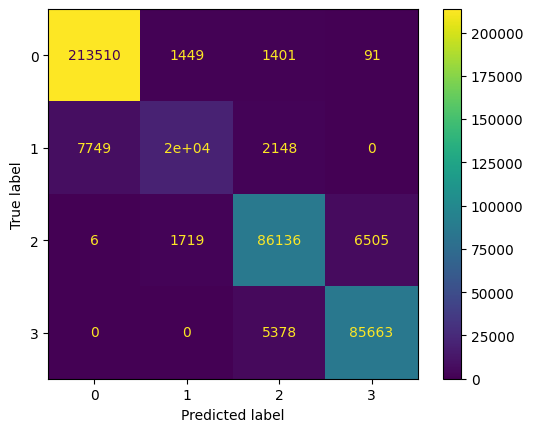

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    216451
           1       0.86      0.67      0.76     30189
           2       0.91      0.91      0.91     94366
           3       0.93      0.94      0.93     91041

    accuracy                           0.94    432047
   macro avg       0.92      0.88      0.89    432047
weighted avg       0.94      0.94      0.94    432047

